# Photometry Classification Pipeline For PLASTICC Dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns

import sys

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, make_scorer, f1_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

import copy
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import cm

from utils import binarization, interpolation, rolling_diff, rolling_ratio, log10_, KFoldsClassifier

from scipy import stats

from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))
    
import copy
import datetime
    
pd.options.display.max_columns = 500

## Data Download

In [2]:
!python download_data.py

Checksum test for ../data/plasticc/note1_dataRelease.pdf PASSED.
Checksum test for ../data/plasticc/note2_modelNames.pdf PASSED.
Checksum test for ../data/plasticc/plasticc_modelpar.tar.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_01.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_06.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_02.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_04.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_08.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_07.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_03.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_lightcurves_05.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_train_metadata.csv.gz PASSED.
Checksum test for ../data/plasticc/plasticc_test_metadata.csv.gz PASSED.
Checksum test for ../dat

## Data Import

In [3]:
metadata = pd.read_csv('../data/plasticc/plasticc_test_metadata.csv.gz')

def set_sn_type(x):
#     if x in {90, 67, 52}:
    if x == 90:
        return 1
    else:
        return 0
    
metadata['is_ia'] = metadata.true_target.apply(set_sn_type)

In [4]:
def agg_to_arr(arr):
    return arr

def get_rms(row):
    weights = 1 / row.flux_err
    mean = np.average(row.flux, weights=weights)
    rms_for_pval = np.sum(np.square((row.flux - mean) * weights))
    return rms_for_pval

def get_pval(row):
    pval = 1.0 - stats.chi2.cdf(row.rms, row.size_r - 1)
    return pval

def normalize(x):
    return np.array(MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))).reshape(1, -1)[0]

def shifting(row):
    x = row.mjd - row.mjd[row.y_normed.argmax()]
    return x

def get_bins(row):
    return binarization(row.x_shifted, row.y_normed, n=16, x_ranges=[-50, 100])

def interpolate(row):
    return interpolation(np.arange(len(row.binarized)), row.binarized)

def generate_features(row):
    return rolling_ratio(row.interpolated)

In [5]:
X = 0
y = 0
flg = 0

In [6]:
for i in range(12):
    if i == 11:
        print('Starting File with Train')
        filename = '../data/plasticc/plasticc_train_lightcurves.csv.gz'
        metadata = pd.read_csv('../data/plasticc/plasticc_train_metadata.csv.gz')
        metadata['is_ia'] = metadata.true_target.apply(set_sn_type)
    else:
        print('Starting File #{0}'.format(i + 1))
        filename = '../data/plasticc/plasticc_test_lightcurves_{:02d}.csv.gz'.format(i + 1)
    data = pd.read_csv(filename)
    print('Read File OK ' + str(datetime.datetime.now().time()))
    
    data = data[(data.passband == 2) & (data.detected_bool == 1)]
    data = data.groupby(by='object_id').agg({'mjd' : list, 
                                         'flux' : list, 
                                         'flux_err' : list, 
                                         'detected_bool' : 'count'})
    print('Group Points By Object OK ' + str(datetime.datetime.now().time()))
    data.rename({'detected_bool' : 'size_r'}, axis=1, inplace=True)
    data.mjd = data.mjd.apply(lambda x: np.array(x))
    data.flux = data.flux.apply(lambda x: np.array(x))
    data.flux_err = data.flux_err.apply(lambda x: np.array(x))
    data = data.join(metadata.set_index('object_id')[['true_target', 'is_ia', 'true_z']])
    print('Join Data with Metadata OK ' + str(datetime.datetime.now().time()))
    data = data[data.true_target.isin({90, 67, 52, 42, 62, 95, 15, 88})]
    data.drop(['true_target'], axis=1, inplace=True)
    data['rms'] = data.apply(get_rms, axis=1)
    data['pval'] = data.apply(get_pval, axis=1)
    print('Calculate P-value OK ' + str(datetime.datetime.now().time()))
    data.pval.fillna(0, inplace=True)
    data = data[(data.pval < 0.001) & (data.size_r >= 4)].reset_index()
    data['y_normed'] = data.flux.apply(normalize)
    data['x_shifted'] = data.apply(shifting, axis=1)
    data['binarized'] = data.apply(get_bins, axis=1)
    data['interpolated'] = data.apply(interpolate, axis=1)
    print('Preprocess OK ' + str(datetime.datetime.now().time()))
    data['rolling_ratios'] = data.apply(generate_features, axis=1)
    print('Generate Features OK ' + str(datetime.datetime.now().time()))
    features_df = pd.DataFrame(np.concatenate((np.stack(data.interpolated.values),
                                               np.stack(data.rolling_ratios.values)), axis=1))
    features_df.columns = ['x_' + str(i) for i in range(16)] + ['d_' + str(i) for i in range(16)]
    xdata = pd.concat([data.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)
    print('Concatenate Features to Initial Dataset OK ' + str(datetime.datetime.now().time()))
    _X = xdata.loc[:, 'x_0':'d_15'].values
    _y = xdata['is_ia'].values
    if flg == 1:
        X = np.concatenate((X, _X))
        y = np.concatenate((y, _y))
    elif flg == 0:
        X = copy.deepcopy(_X)
        y = copy.deepcopy(_y)
        flg = 1
    del _X
    del _y
    print('Append to X, y OK ' + str(datetime.datetime.now().time()))

Starting File #1
Read File OK 14:41:59.404748
Group Points By Object OK 14:42:03.389659
Join Data with Metadata OK 14:42:05.866769
Calculate P-value OK 14:42:12.787213
Preprocess OK 14:42:18.909582
Generate Features OK 14:42:19.216477
Concatenate Features to Initial Dataset OK 14:42:19.273820
Append to X, y OK 14:42:19.283568
Starting File #2
Read File OK 14:43:01.786285
Group Points By Object OK 14:43:31.215684
Join Data with Metadata OK 14:43:35.257876
Calculate P-value OK 14:44:40.640874
Preprocess OK 14:45:09.111964
Generate Features OK 14:45:11.027233
Concatenate Features to Initial Dataset OK 14:45:11.328195
Append to X, y OK 14:45:11.352610
Starting File #3
Read File OK 14:45:58.223261
Group Points By Object OK 14:46:32.694466
Join Data with Metadata OK 14:46:37.014986
Calculate P-value OK 14:47:49.313507
Preprocess OK 14:48:17.701642
Generate Features OK 14:48:18.888348
Concatenate Features to Initial Dataset OK 14:48:19.331652
Append to X, y OK 14:48:19.383367
Starting File #4

In [7]:
print(np.histogram(data['true_z'], bins=10, range=(0,2)))
print(np.count_nonzero(data['true_z'] <= 0.6) / data.shape[0])
print(np.histogram(data['size_r'], bins=10, range=(0,100)))

(array([892, 946, 355, 142,  77,  44,  26,  34,  31,  21]), array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]))
0.8418426103646833
(array([1631,  745,  119,   19,   45,   46,    0,    0,    0,    0]), array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]))


In [8]:
# import pickle

# with open('y_plasticc.pickle', 'rb') as f:
#     y = pickle.load(f)
    
# with open('X_plasticc.pickle', 'rb') as f:
#     X = pickle.load(f)

In [9]:
y.sum() / len(y)

0.4650194803374723

In [10]:
y.sum()

199086

In [11]:
X.shape

(428124, 32)

In [12]:
y.shape

(428124,)

In [13]:
a = np.concatenate((X, y.reshape(-1, 1)), axis=1)

In [14]:
not_ia = a[a[:, -1] == 0]
ia = a[a[:, -1] == 1]

In [15]:
shape = not_ia[:, -1].shape
n_samples = 59047
inds = np.random.randint(0, shape[0], size=n_samples)
notia_sample = not_ia[inds]

In [16]:
notia_sample.shape

(59047, 33)

In [17]:
b = np.concatenate((ia, notia_sample), axis=0)
b.shape

(258133, 33)

In [18]:
X = b[:, :-1]
y = b[:, -1]

In [19]:
X.shape

(258133, 32)

In [20]:
y.shape

(258133,)

## Train Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Models

### Random Forest 
#### Train: PLASTiCC 
#### Test: PLASTiCC

In [22]:
rf = RandomForestClassifier(n_estimators=5000,
                            min_samples_split=10, 
                            min_samples_leaf=2, 
                            max_features='auto',
                            bootstrap=True, 
                            max_depth=30, 
                            n_jobs=-1, 
                            random_state=25, verbose=1)

rf.fit(X_train, y_train)
rf_pred = rf.predict_proba(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 24.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 31.5min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 31.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4

### Random Forest 
#### Train: PLASTiCC 
#### Test: OSC

In [23]:
import pickle

In [24]:
with open('X_osc.pickle', 'rb') as f:
    X_osc = pickle.load(f)
    
with open('y_osc.pickle', 'rb') as f:
    y_osc = pickle.load(f)

In [25]:
plasticc_osc = rf.predict_proba(X_osc)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:    8.5s finished


### Random Forest 
#### Train: OSC
#### Test: PLASTiCC

In [26]:
with open('rf_osc_model.sav', 'rb') as f:
    osc_rf_model = pickle.load(f)

osc_plasticc = osc_rf_model.predict_proba(X)

### Random Forest 
#### Train: OSC
#### Test: OSC

In [27]:
with open('OSC_rf_y_pred.pickle', 'rb') as f:
    osc_osc = pickle.load(f)
    
with open('OSC_y_true.pickle', 'rb') as f:
    osc_y_true = pickle.load(f)

### Model Evaluation

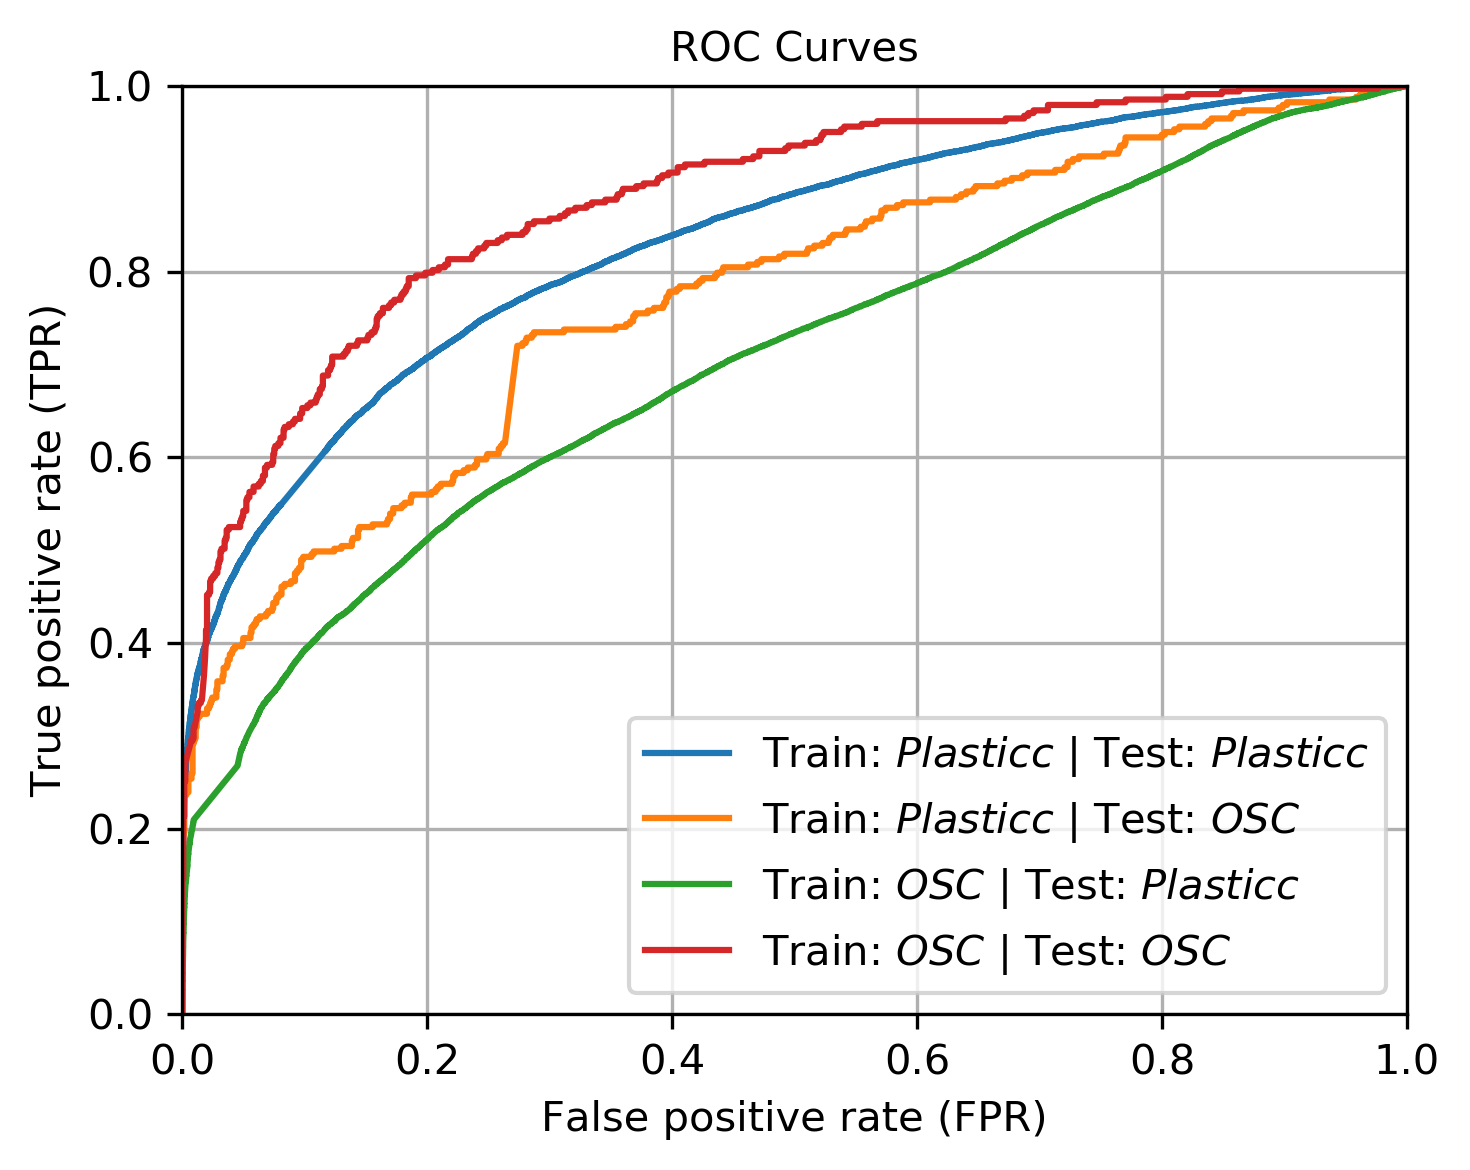

In [28]:
scores_table = []

fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=300)
ax.set_xlabel('False positive rate (FPR)')
ax.set_ylabel('True positive rate (TPR)')
ax.set_xlim(0., 1)
ax.set_ylim(0., 1)
ax.set_title(r'ROC Curves', fontsize=10)
ax.grid(b=0.1)

colors = ['C0', 'C1', 'C2', 'C3']
labels = ['Train: $Plasticc$ | Test: $Plasticc$',
         'Train: $Plasticc$ | Test: $OSC$',
         'Train: $OSC$ | Test: $Plasticc$',
         'Train: $OSC$ | Test: $OSC$']

for i, train_test in enumerate([(y_test, rf_pred),
                              (y_osc, plasticc_osc),
                              (y, osc_plasticc),
                              (osc_y_true, osc_osc)]):
    try:
        fpr, tpr, thresholds = roc_curve(train_test[0], train_test[1][:, 1])
        ax.plot(1-tpr, 1-fpr, linewidth=1.5, label=labels[i], color=colors[i])
        auc = roc_auc_score(train_test[0], train_test[1][:, 1])
        acc = accuracy_score(train_test[0], train_test[1][:, 1]>=0.5)
        f1 = f1_score(train_test[0], train_test[1][:, 1]>=0.5)
        pr = precision_score(train_test[0], train_test[1][:, 1]>=0.5)
        rec = recall_score(train_test[0], train_test[1][:, 1]>=0.5)
    except:
        fpr, tpr, thresholds = roc_curve(train_test[0], train_test[1])
        ax.plot(1-tpr, 1-fpr, linewidth=1.5, label=labels[i], color=colors[i])
        auc = roc_auc_score(train_test[0], train_test[1])
        acc = accuracy_score(train_test[0], train_test[1]>=0.5)
        f1 = f1_score(train_test[0], train_test[1]>=0.5)
        pr = precision_score(train_test[0], train_test[1]>=0.5)
        rec = recall_score(train_test[0], train_test[1]>=0.5)
    scores_table.append([auc, acc, f1, pr, rec])
    
ax.legend()
plt.tight_layout()
plt.savefig('images/roc_plasticc.pdf')
plt.show()

In [29]:
std_errors = {}

In [30]:
for i, train_test in enumerate([(y_test, rf_pred),
                              (y_osc, plasticc_osc),
                              (y, osc_plasticc),
                              (osc_y_true, osc_osc)]):
    bs_auc = []
    bs_acc = []
    bs_f1 = []
    bs_pr = []
    bs_rec = []
    
    for j in range(1000):
        idx = np.random.choice([i for i in range(len(train_test[0]))], len(train_test[0]))
        try:
            bs_auc.append(roc_auc_score(train_test[0][idx], train_test[1][idx][:, 1]))
            bs_acc.append(accuracy_score(train_test[0][idx], train_test[1][idx][:, 1]>=0.5))
            bs_f1.append(f1_score(train_test[0][idx], train_test[1][idx][:, 1]>=0.5))
            bs_pr.append(precision_score(train_test[0][idx], train_test[1][idx][:, 1]>=0.5))
            bs_rec.append(recall_score(train_test[0][idx], train_test[1][idx][:, 1]>=0.5))
        except:
            bs_auc.append(roc_auc_score(train_test[0][idx], train_test[1][idx]))
            bs_acc.append(accuracy_score(train_test[0][idx], train_test[1][idx]>=0.5))
            bs_f1.append(f1_score(train_test[0][idx], train_test[1][idx]>=0.5))
            bs_pr.append(precision_score(train_test[0][idx], train_test[1][idx]>=0.5))
            bs_rec.append(recall_score(train_test[0][idx], train_test[1][idx]>=0.5))
    std_errors[labels[i]] = [np.std(bs_auc), np.std(bs_acc), np.std(bs_f1), np.std(bs_pr), np.std(bs_rec)]
    print(std_errors)
    print('model done')

{'Train: $Plasticc$ | Test: $Plasticc$': [0.0018725055470822302, 0.001312305966131418, 0.0008554520268527587, 0.0013833509879351107, 0.0006430404279364172]}
model done
{'Train: $Plasticc$ | Test: $Plasticc$': [0.0018725055470822302, 0.001312305966131418, 0.0008554520268527587, 0.0013833509879351107, 0.0006430404279364172], 'Train: $Plasticc$ | Test: $OSC$': [0.015683504717792576, 0.01020866889349255, 0.0070378292879506215, 0.010344855559036234, 0.007745164166018088]}
model done
{'Train: $Plasticc$ | Test: $Plasticc$': [0.0018725055470822302, 0.001312305966131418, 0.0008554520268527587, 0.0013833509879351107, 0.0006430404279364172], 'Train: $Plasticc$ | Test: $OSC$': [0.015683504717792576, 0.01020866889349255, 0.0070378292879506215, 0.010344855559036234, 0.007745164166018088], 'Train: $OSC$ | Test: $Plasticc$': [0.00128174739247768, 0.0008094338473503311, 0.0005645442037101263, 0.0007798329229699391, 0.0006989078768262407]}
model done
{'Train: $Plasticc$ | Test: $Plasticc$': [0.00187250

In [31]:
errs = pd.DataFrame(std_errors)
errs.columns = ['Plasticc-Plasticc', 'Plasticc-OSC', 'OSC-Plasticc', 'OSC-OSC']
errs.index = ['AUC', 'Acc', 'F1', 'Pr', 'Rec']
errs

,Plasticc-Plasticc,Plasticc-OSC,OSC-Plasticc,OSC-OSC
AUC,0.001873,0.015684,0.001282,0.011233
Acc,0.001312,0.010209,0.000809,0.008715
F1,0.000855,0.007038,0.000565,0.005703
Pr,0.001383,0.010345,0.000780,0.009060
Rec,0.000643,0.007745,0.000699,0.005410


In [32]:
pd.options.display.float_format = "{:.3f}".format

scores_df = pd.DataFrame(scores_table).T
scores_df.index = ['AUC', 'Acc', 'F1-Score', 'Precision', 'Recall']
scores_df.columns = ['Plasticc-Plasticc', 'Plasticc-OSC', 'OSC-Plasticc', 'OSC-OSC']
scores_df

,Plasticc-Plasticc,Plasticc-OSC,OSC-Plasticc,OSC-OSC
AUC,0.832,0.771,0.702,0.876
Acc,0.847,0.815,0.780,0.864
F1-Score,0.908,0.885,0.862,0.917
Precision,0.850,0.853,0.834,0.874
Recall,0.974,0.921,0.891,0.964


In [33]:
np.sum(y) / len(y)

0.7712535785815839

In [34]:
np.sum(y_osc) / len(y_osc)

0.7753765553372626

Text(0.5, 1, 'Plasticc-Plasticc')

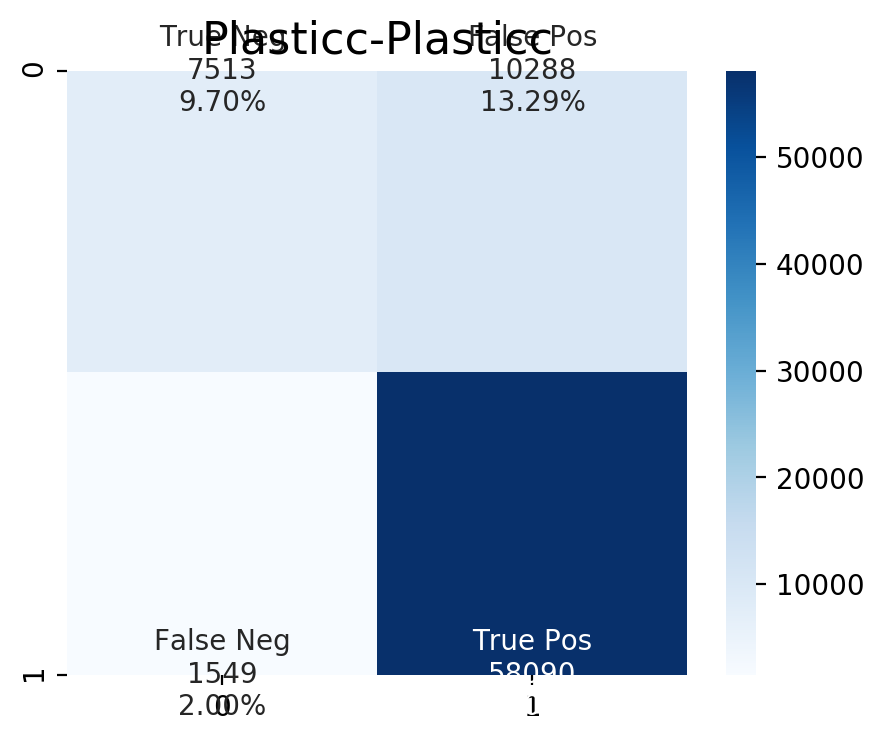

In [35]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, rf_pred[:, 1]>=0.5)

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)
plt.title('Plasticc-Plasticc',fontsize=16)

Text(0.5, 1, 'Plasticc-OSC')

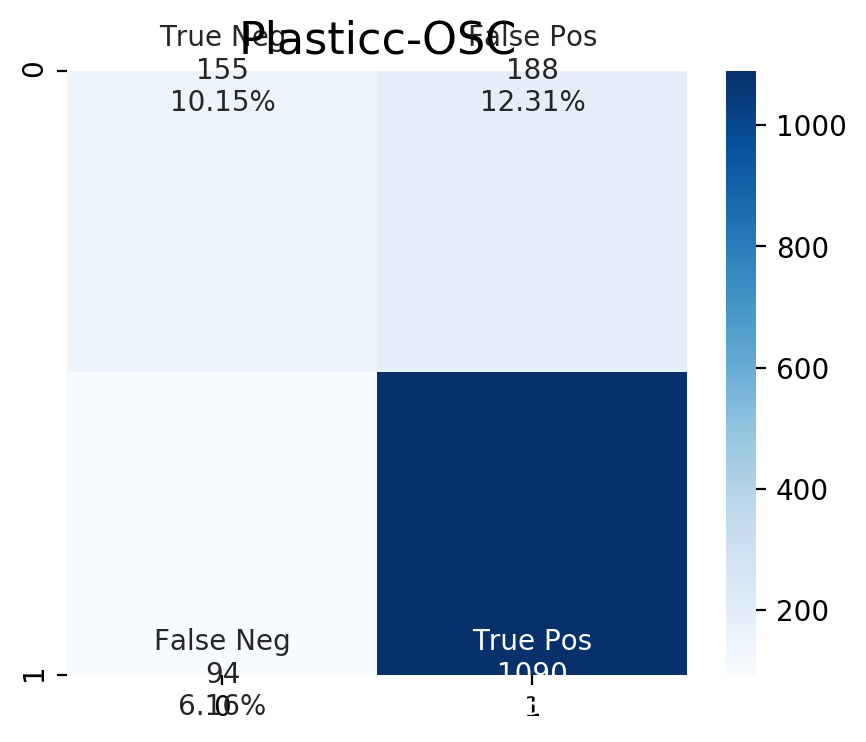

In [36]:
cf_matrix = confusion_matrix(y_osc, plasticc_osc[:, 1]>=0.5)

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)
plt.title('Plasticc-OSC',fontsize=16)

Text(0.5, 1, 'OSC-Plasticc')

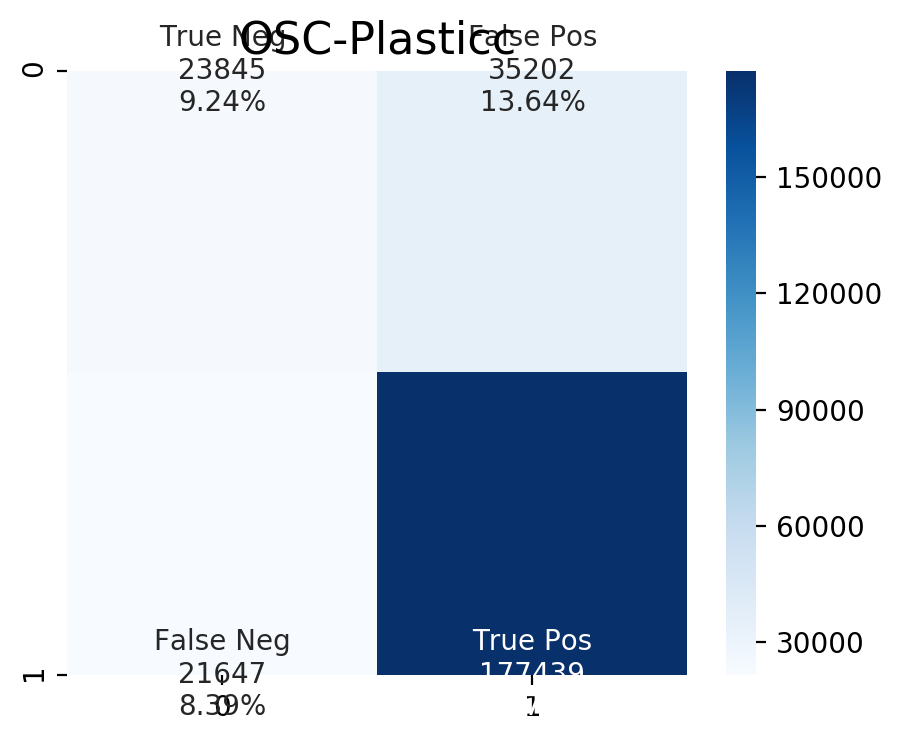

In [37]:
cf_matrix = confusion_matrix(y, osc_plasticc[:, 1]>=0.5)

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)
plt.title('OSC-Plasticc',fontsize=16)

Text(0.5, 1, 'OSC-OSC')

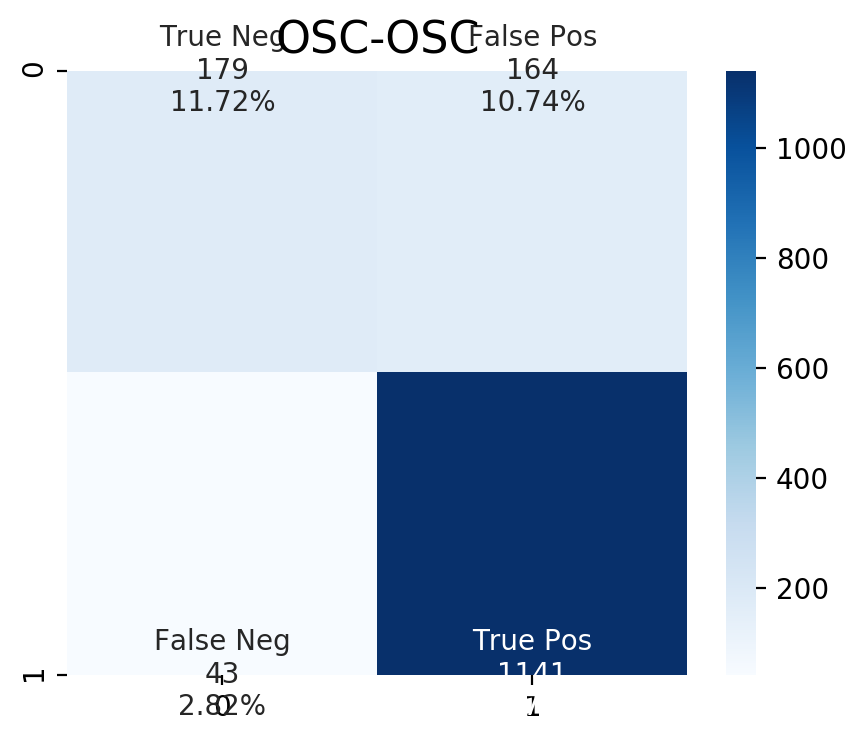

In [38]:
cf_matrix = confusion_matrix(osc_y_true, osc_osc>=0.5)

fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', ax=ax)
plt.title('OSC-OSC',fontsize=16)